# Probabilistic Approach

In [1]:
###------------------
### Import statements
###------------------

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.datasets import make_moons
from collections import Counter

from matplotlib.ticker import (MultipleLocator, 
                               FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..','..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.1
N_SAMPLES = 1000
ALPHA = 0.001

# parameters for Matplotlib
params = {'legend.fontsize': 'small',
          'figure.figsize': (15, 7),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE = 0.2

<Figure size 1500x700 with 0 Axes>

In [3]:
boston_housing = os.path.join(inpDir, moduleDir, 'boston_house_price.csv') # construct full path

data_df = pd.read_csv(boston_housing) # no changes required

data_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


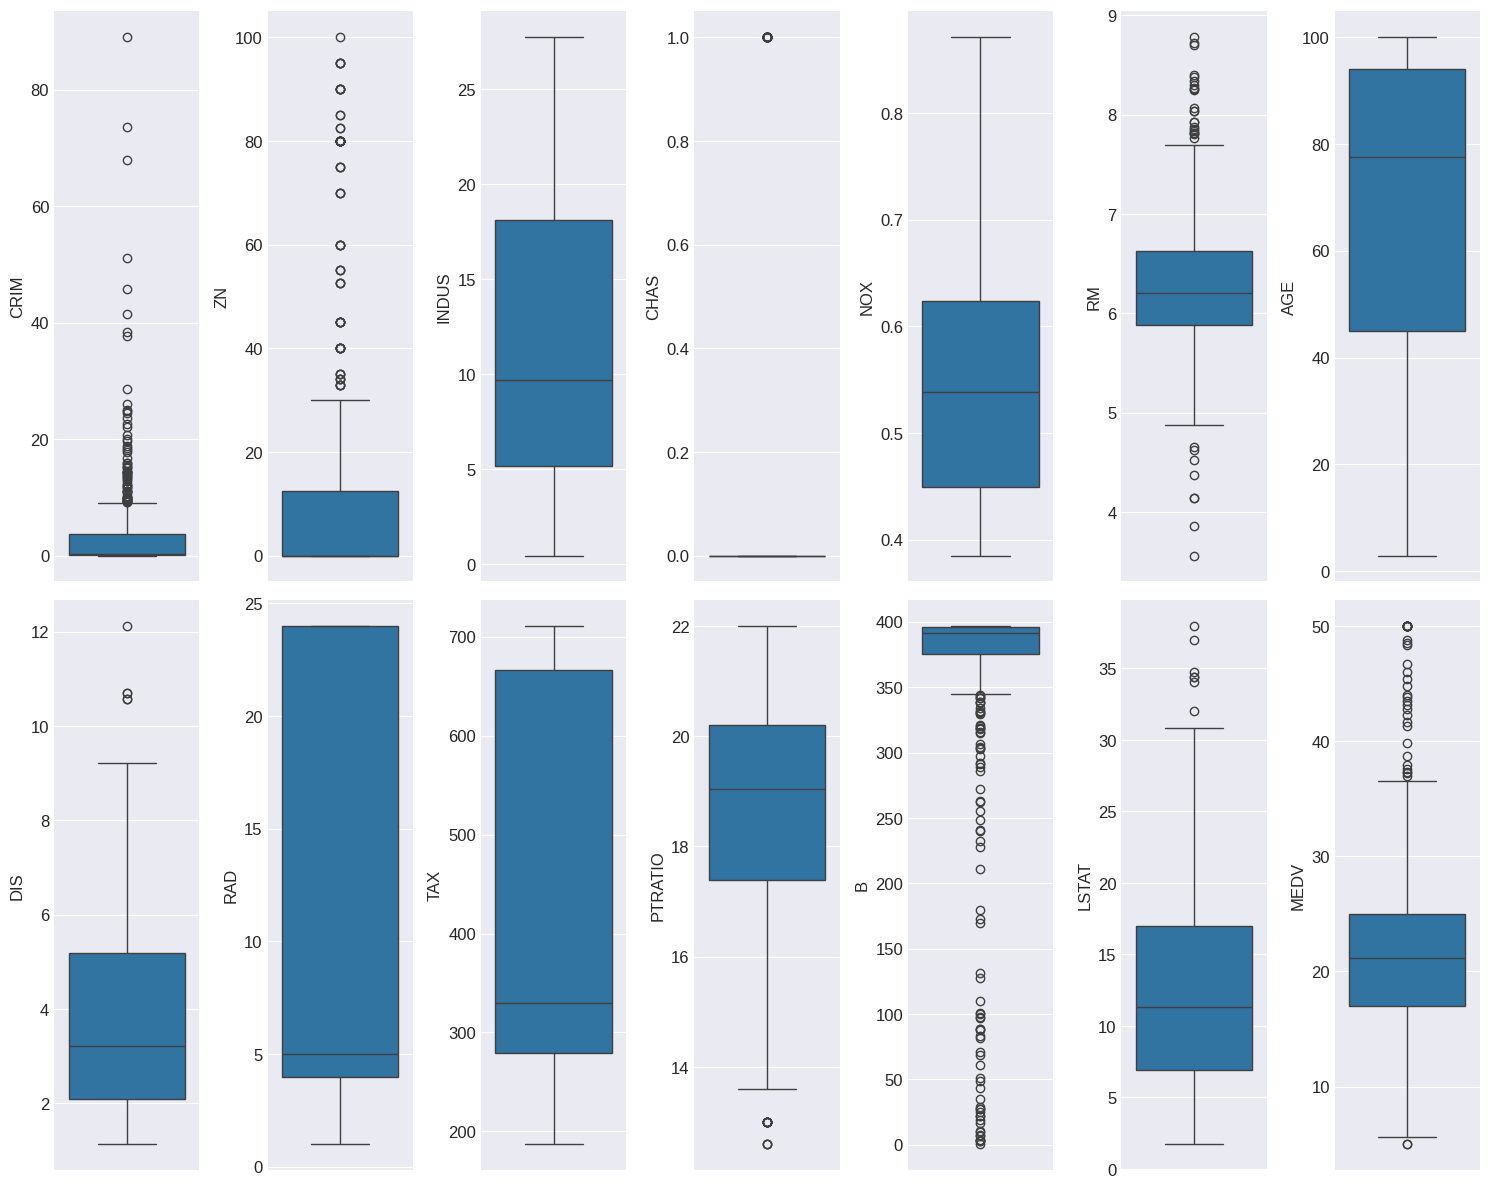

In [5]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(15,12))

axes= axes.ravel()

for count, col in enumerate(data_df.columns):
    ax = axes[count]
    sns.boxplot(data=data_df, y=col, ax = ax)
plt.tight_layout()

In [6]:
print ('Before: ', data_df.shape)

data_df = data_df[data_df['MEDV'] < 50].copy() ## Hard Coded

print ('After: ', data_df.shape)


Before:  (506, 14)
After:  (490, 14)


In [7]:
outlier_list = []

for count, col in enumerate(data_df.columns):

    Q1 = np.percentile(data_df[col], 25) # Quartile 1

    Q3 = np.percentile(data_df[col], 75) # Quartile 3

    outlier_dist = (Q3-Q1) * 1.5 # IQR ## Hard Coded

    outlier_list.extend(data_df[data_df[col] < Q1 - outlier_dist].index) # how many below the whisker
    outlier_list.extend(data_df[data_df[col] > Q3 + outlier_dist].index) # howmany above the whisker

len(outlier_list)

307

In [8]:
outlier_count = Counter(outlier_list)
#outlier_count

In [1]:
print ('Before: ', data_df.shape)
data_df = data_df.drop([412, 414], axis=0).copy()
data_df.reset_index(inplace=True, drop = True)
print ('After: ', data_df.shape)

NameError: name 'data_df' is not defined

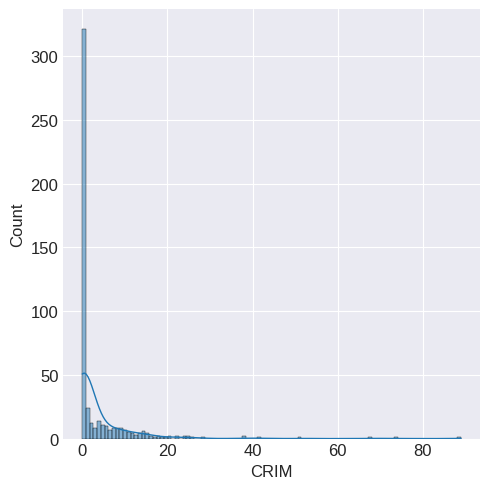

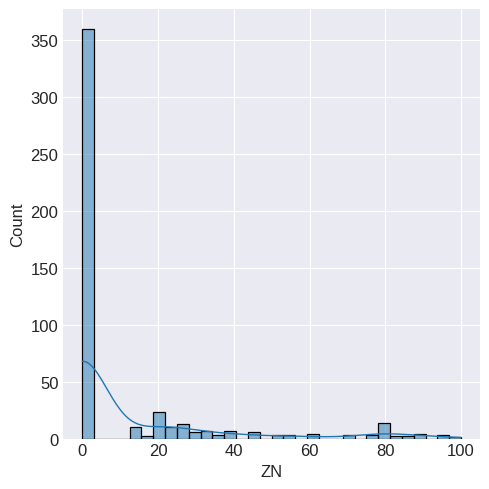

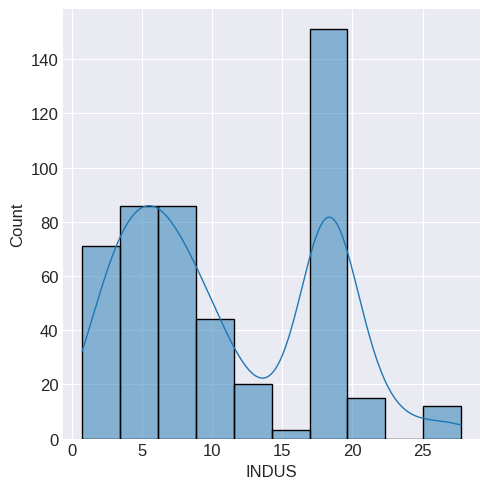

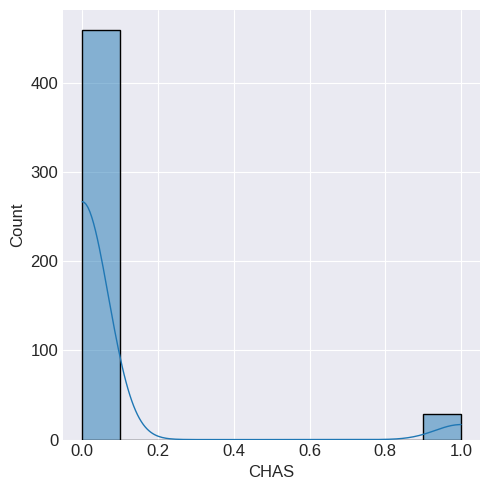

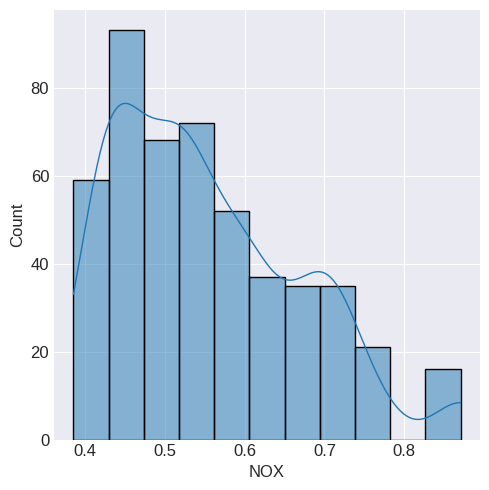

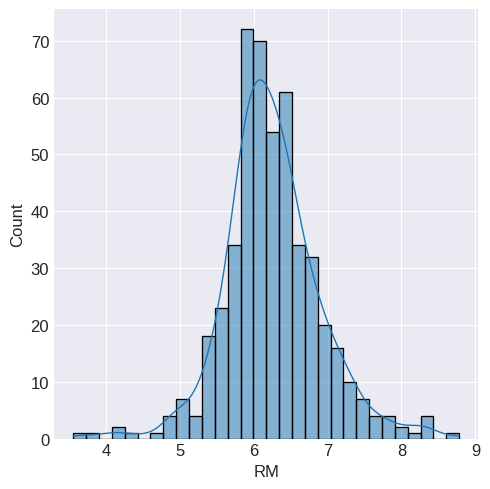

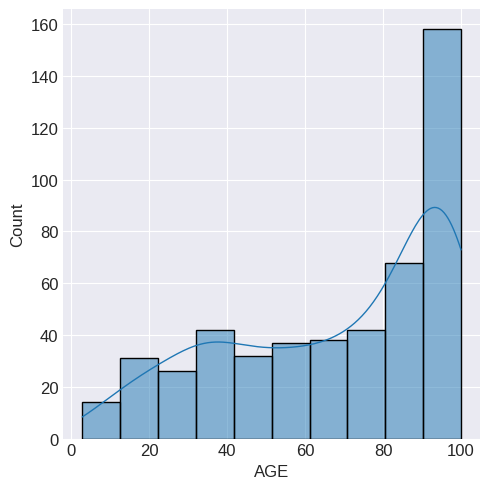

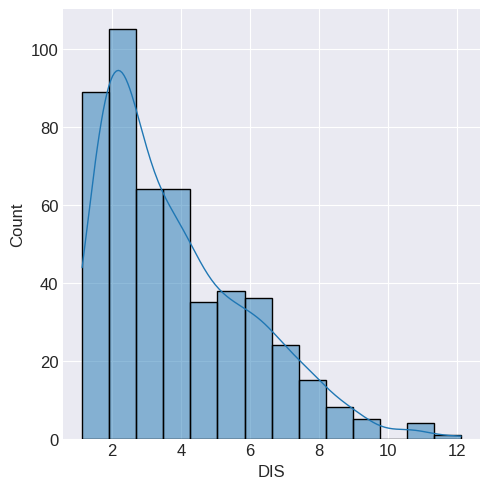

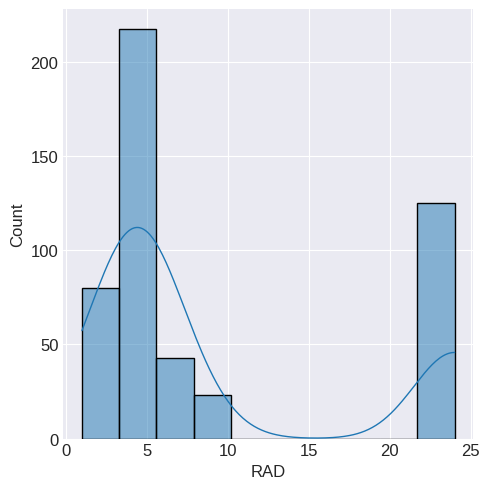

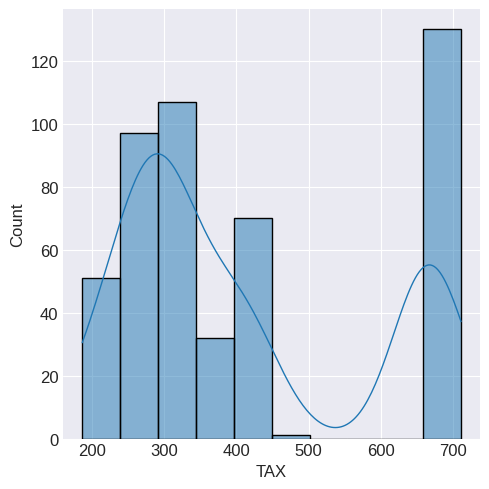

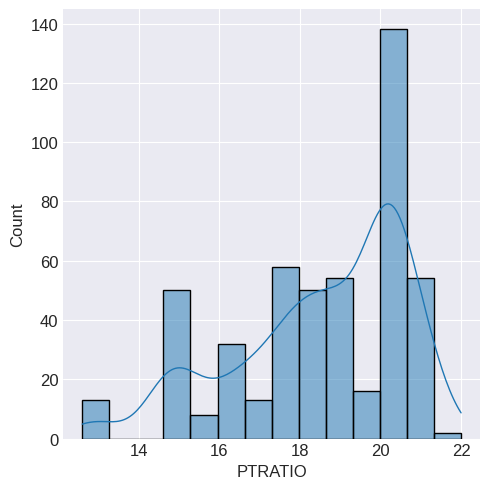

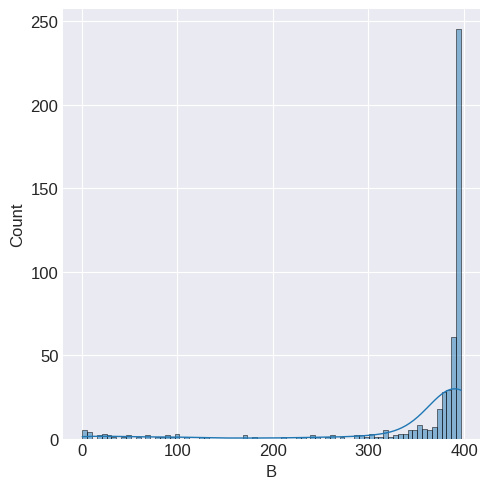

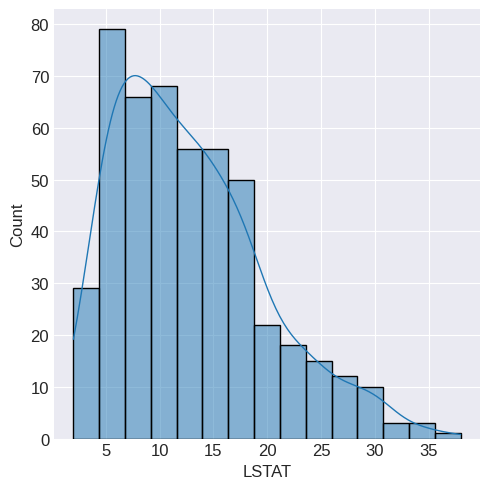

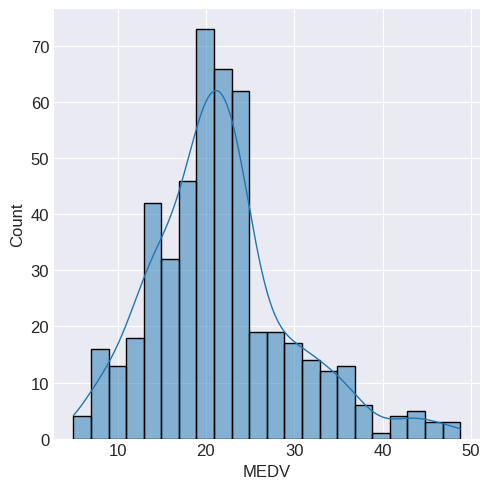

In [10]:
for count, col in enumerate(data_df.columns):

    sns.displot(data=data_df, x =col, kde=True) # distribution plots

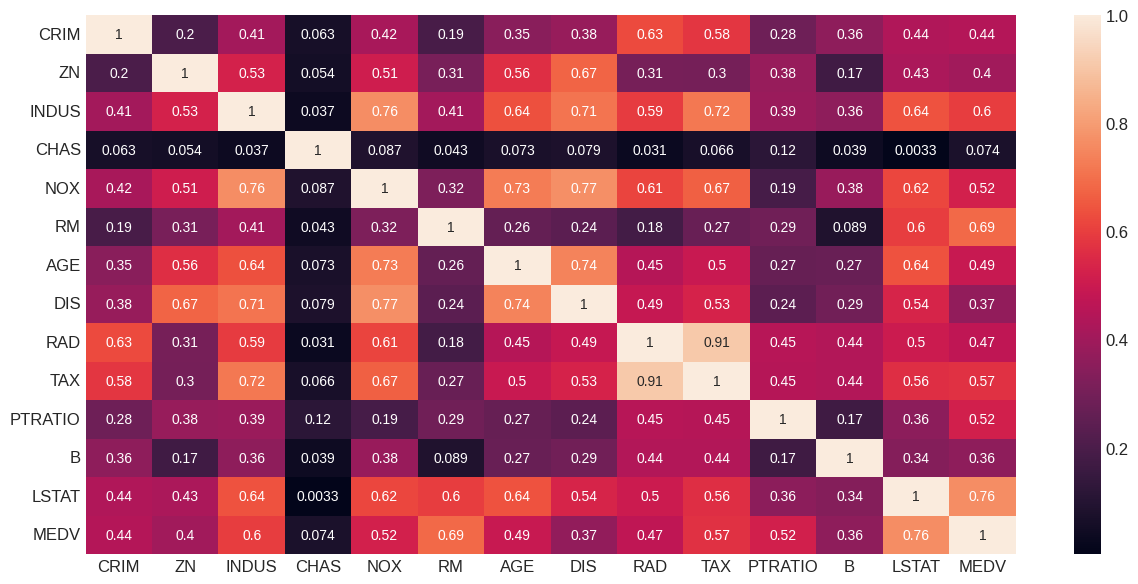

In [11]:
plt.figure()

sns.heatmap(data_df.corr().abs(), annot=True);

In [12]:
col_sel = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'RAD', 'TAX',
       'PTRATIO', 'LSTAT']

features_df = data_df[col_sel].copy()

target = data_df['MEDV']

print (features_df.shape, target.shape)

(488, 10) (488,)


In [13]:
features_df.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,RAD,TAX,PTRATIO,LSTAT
0,0.00632,18.0,2.31,0.538,6.575,65.2,1.0,296.0,15.3,4.98
1,0.02731,0.0,7.07,0.469,6.421,78.9,2.0,242.0,17.8,9.14
2,0.02729,0.0,7.07,0.469,7.185,61.1,2.0,242.0,17.8,4.03
3,0.03237,0.0,2.18,0.458,6.998,45.8,3.0,222.0,18.7,2.94
4,0.06905,0.0,2.18,0.458,7.147,54.2,3.0,222.0,18.7,5.33


In [14]:
scaler = MinMaxScaler()
features_df = pd.DataFrame(data=scaler.fit_transform(features_df), columns=col_sel)
features_df.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,RAD,TAX,PTRATIO,LSTAT
0,0.000000,0.18,0.058148,0.314815,0.577505,0.641607,0.000000,0.208015,0.287234,0.083356
1,0.000236,0.00,0.234444,0.172840,0.547998,0.782698,0.043478,0.104962,0.553191,0.198944
2,0.000236,0.00,0.234444,0.172840,0.694386,0.599382,0.043478,0.104962,0.553191,0.056960
3,0.000293,0.00,0.053333,0.150206,0.658555,0.441813,0.086957,0.066794,0.648936,0.026674
4,0.000705,0.00,0.053333,0.150206,0.687105,0.528321,0.086957,0.066794,0.648936,0.093081


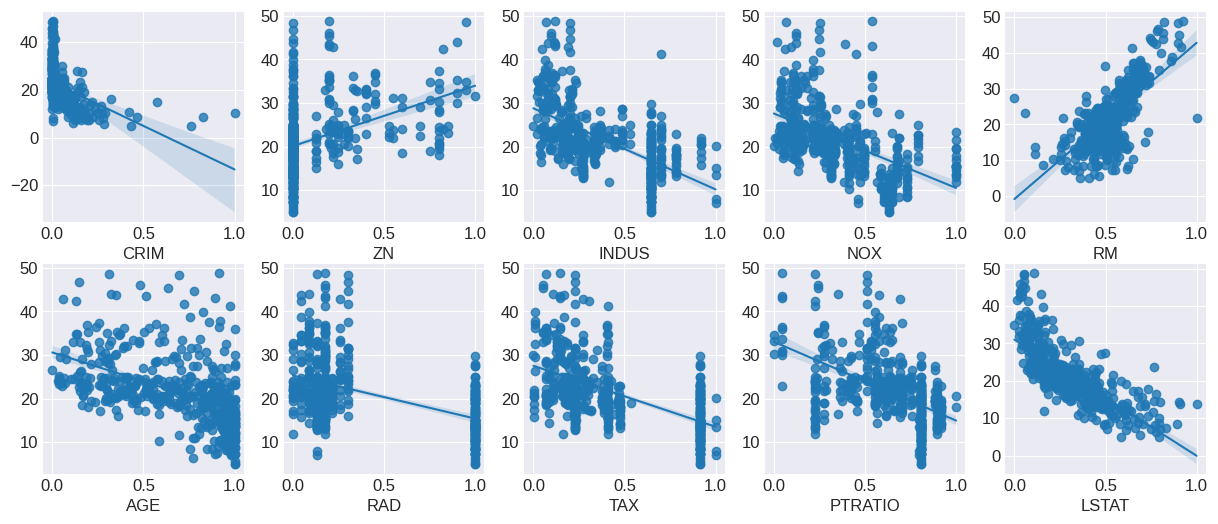

In [15]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15,6))
axes = axes.ravel()

for count, col in enumerate(col_sel):

    sns.regplot(x = features_df[col], y=target.to_numpy(), ax = axes[count])


## Eliminate Skew

In [16]:
target

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
483    22.4
484    20.6
485    23.9
486    22.0
487    11.9
Name: MEDV, Length: 488, dtype: float64

In [17]:
y = np.log1p(target.to_numpy()) # 

for col in features_df.columns:

    skw = features_df[col].skew()

    print (f'Column {col}: Skew: {skw:7.4f}')

    if np.abs(skw) > 0.3: #address if skew is more than 0.3 ## Hard Coded

        print ('transforming column:', col)

        features_df[col] = np.log1p(features_df[col]) # take log
        

Column CRIM: Skew:  5.3802
transforming column: CRIM
Column ZN: Skew:  2.2348
transforming column: ZN
Column INDUS: Skew:  0.3314
transforming column: INDUS
Column NOX: Skew:  0.7616
transforming column: NOX
Column RM: Skew:  0.2215
Column AGE: Skew: -0.5828
transforming column: AGE
Column RAD: Skew:  1.0311
transforming column: RAD
Column TAX: Skew:  0.6932
transforming column: TAX
Column PTRATIO: Skew: -0.8175
transforming column: PTRATIO
Column LSTAT: Skew:  0.8605
transforming column: LSTAT


In [18]:
#features_df.max()

In [19]:
reg = LinearRegression()

kf = KFold(n_splits=10) ## Hard Coded

scores = cross_val_score(reg, features_df.to_numpy(), y, cv=kf, scoring='neg_mean_squared_error')

In [20]:
scores.mean(), scores.std()

(-0.03723700729265783, 0.02840445844864473)

In [21]:
reg.fit(features_df.to_numpy(), y)
y_pred = reg.predict(features_df.to_numpy())

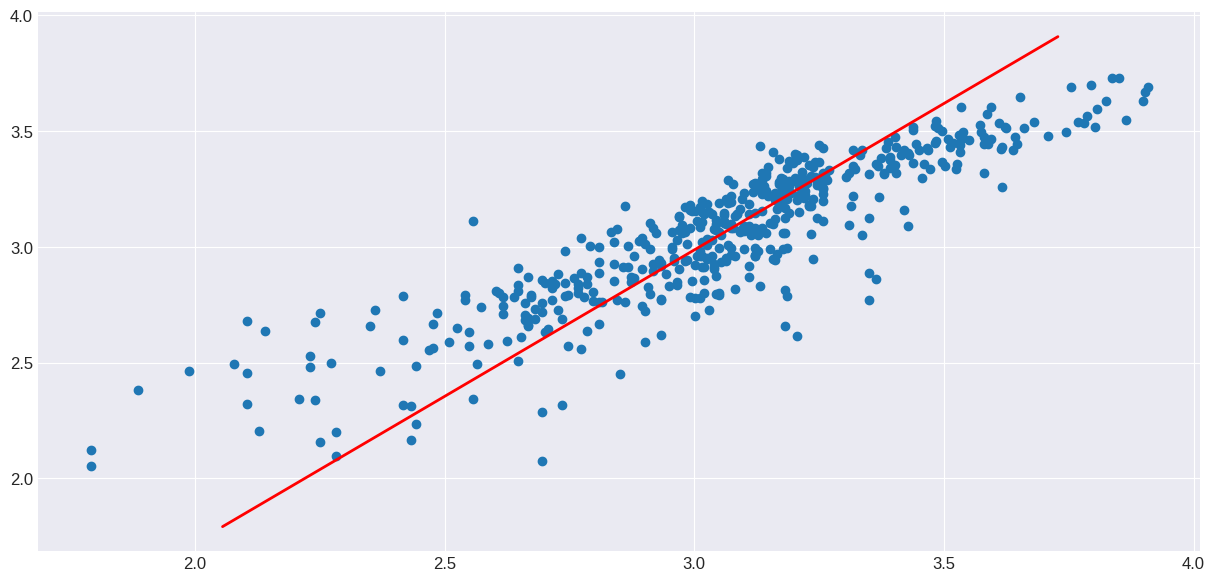

In [22]:
plt.scatter(y, y_pred)

plt.plot([y_pred.min(), y_pred.max()], [y.min(), y.max()], c = 'r', lw = 2);

# Logistic Regression

In [23]:
X, y = make_moons(n_samples=N_SAMPLES, noise=NOISE, shuffle=True, random_state=RANDOM_STATE)

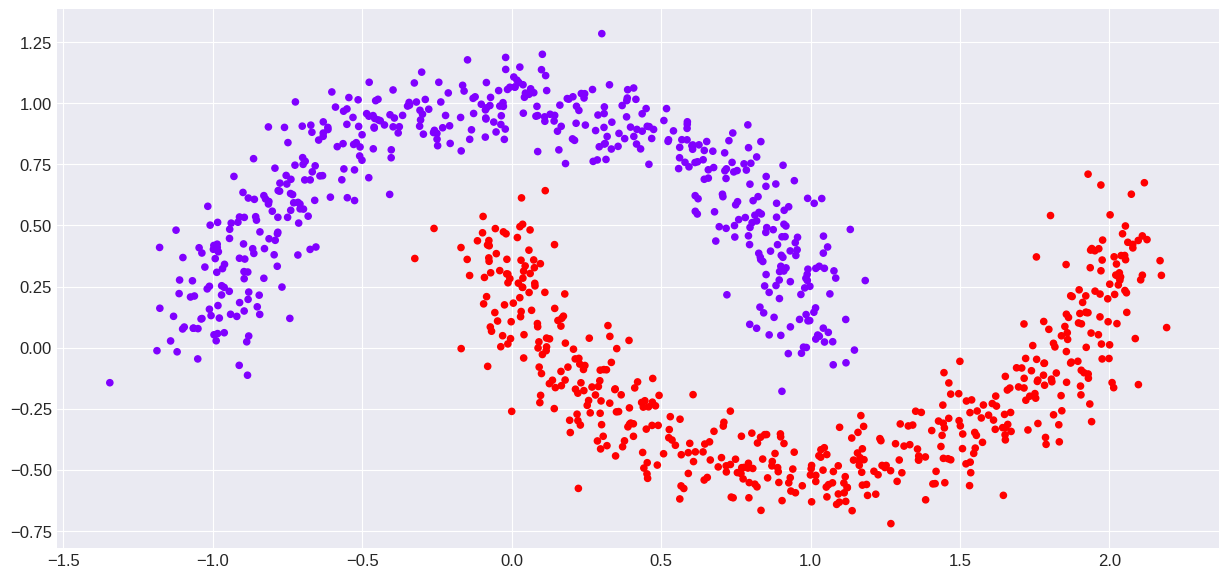

In [24]:
plt.scatter(X[:,0], X[:, 1], s=20, c=y, cmap=CMAP);

In [25]:
clf = LogisticRegression(penalty=None, random_state=RANDOM_STATE)

clf.fit(X, y)

y_pred = clf.predict(X[:2, :])

Object `LogisticRegression` not found.


In [26]:
clf.predict_proba(X[:3, :])

array([[0.95143545, 0.04856455],
       [0.99034282, 0.00965718],
       [0.32041645, 0.67958355]])

In [27]:
clf.score(X,y)

0.881

In [28]:
X

array([[ 0.79254123,  0.81852609],
       [-0.86341583,  0.77353281],
       [ 1.94098477,  0.40538635],
       ...,
       [ 0.31950406,  0.86437406],
       [ 1.76039532, -0.13329496],
       [-0.91576933,  0.51324915]])

In [29]:
def fn_plot_decision_boundary(clf_, X, y):

    fig, ax = plt.subplots(figsize = (10,6))

    dm = 0.01

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5 
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(np.arange(x_min, x_max, dm), np.arange(y_min, y_max, dm))

    zz = np.c_[xx.ravel(), yy.ravel()]

    y_pred = clf_.predict(zz)

    z = np.array(y_pred).reshape(xx.shape)

    ax.contourf(xx,yy, z, alpha = 0.6, cmap=CMAP)

    ax.scatter(X[:,0], X[:,1], c = y, s = 10, marker='*', cmap=plt.cm.coolwarm)

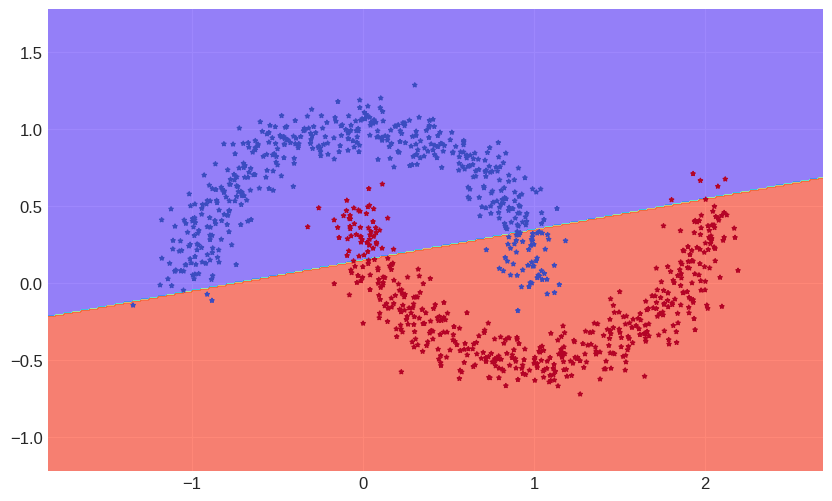

In [30]:
fn_plot_decision_boundary(clf, X, y)

## MultiClass - One vs. Rest

In [31]:
# CSV file name
iris_file = os.path.join(inpDir, moduleDir, 'iris.csv')

# Define feature names

iris_features = ['sepal length',
                 'sepal width',
                 'petal length',
                 'petal width',
                 'target']
# Read the CSV file
iris_df = pd.read_csv(iris_file, sep=',', skiprows=1, 
                      header=None, names = iris_features)

### Some EDA

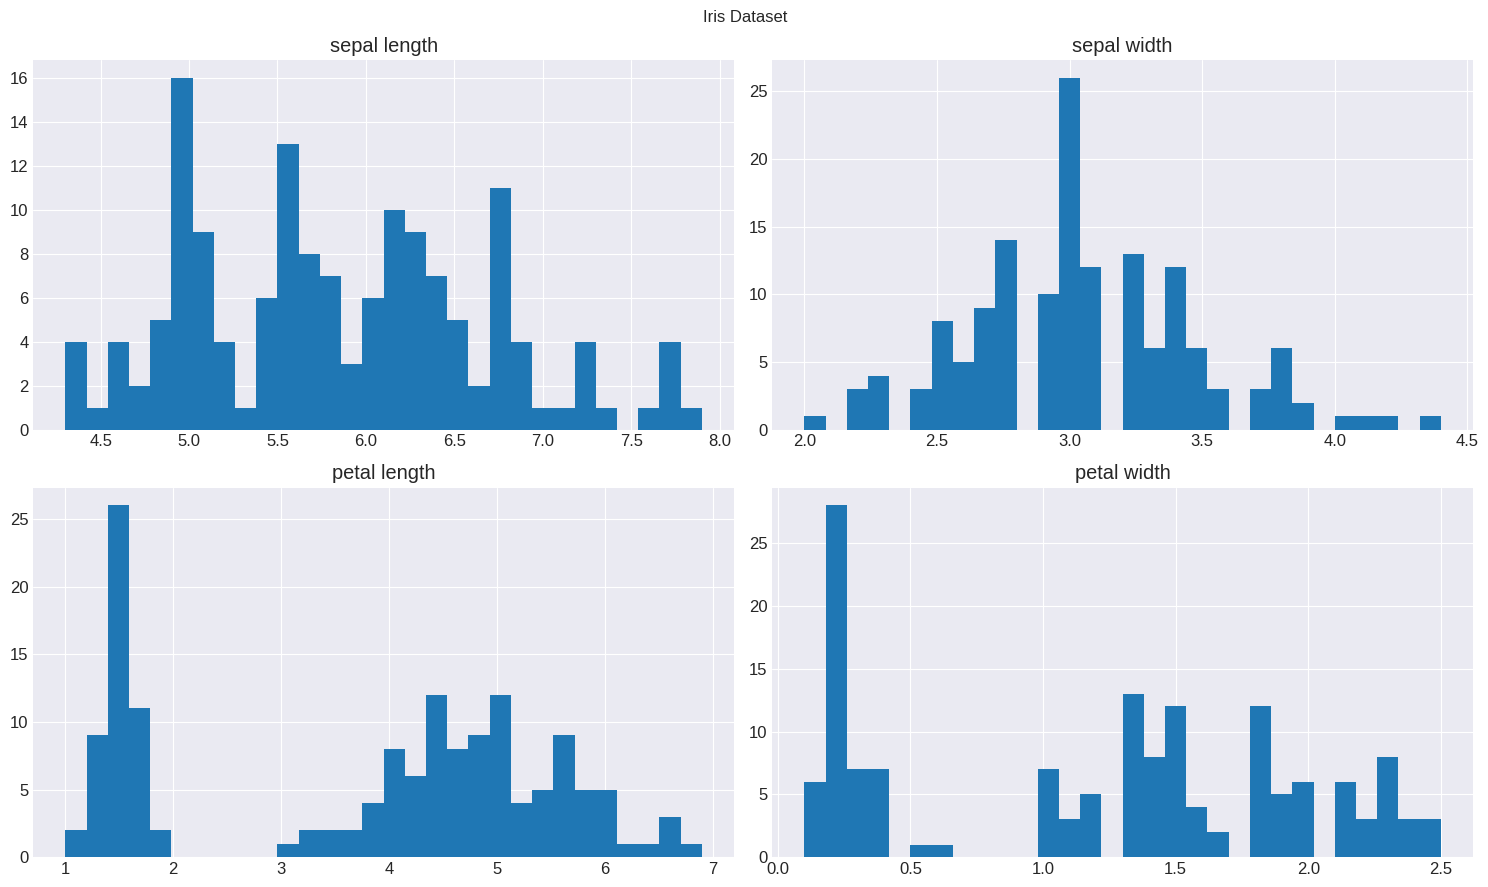

In [32]:
# Plot the features
fig = plt.figure( figsize = (15 , 9) )

fig.suptitle('Iris Dataset')

for count, col in enumerate(iris_df.columns[:-1]):
    
        # Add the first set of axes (subplot 1)
        ax = fig.add_subplot(2, 2, count+1)  # 2 row, 2 columns
                
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        
        n, bins, patches = ax.hist( iris_df [col], 30)
        
        ax.set_title('{}'.format(iris_df.columns[count]))
        
        ax.axis('tight')

        #plt.legend(loc = 'best')

plt.tight_layout()

plt.show()

### Feature Extraction

In [33]:
features = iris_df.drop('target',axis=1)
labels = iris_df['target']

In [34]:
#train_test_split?

### Split the data in Train and Test set

In [35]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                    stratify=labels,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape,  y_test.shape

((120, 4), (30, 4), (120,), (30,))

### Scale Data separately

In [36]:
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
y_train = y_train.to_numpy()

X_test = scaler.transform(X_test)
y_test = y_test.to_numpy()

## Helper Functions

In [37]:
# Some helpers to format the plot
target_names = ['setosa','versicolor','virginica']

# this formatter will label the colorbar with the correct target names
formatter = plt.FuncFormatter(lambda i, *args: target_names[int(i)])

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='aqua', alpha=0.5)

In [38]:
# instantiate
clf= LogisticRegression(penalty=None,
                        multi_class='ovr',
                        random_state=RANDOM_STATE)


# fit the classifier
clf.fit(X_train, y_train)

# make predictions
y_pred = clf.predict(X_test)

y_pred = np.hstack([clf.predict(X_train), y_pred])
y = np.hstack([y_train, y_test])

In [39]:
y.shape, y_pred.shape

((150,), (150,))

In [40]:
# Let's use first two columns of the data and plot the data to visualize the results
xplot = iris_df.keys()[0]

yplot = iris_df.keys()[1]


# also locate instances which are incorrectly predicted.
x_err = iris_df[xplot][(y != y_pred)]
y_err = iris_df[yplot][(y != y_pred)]

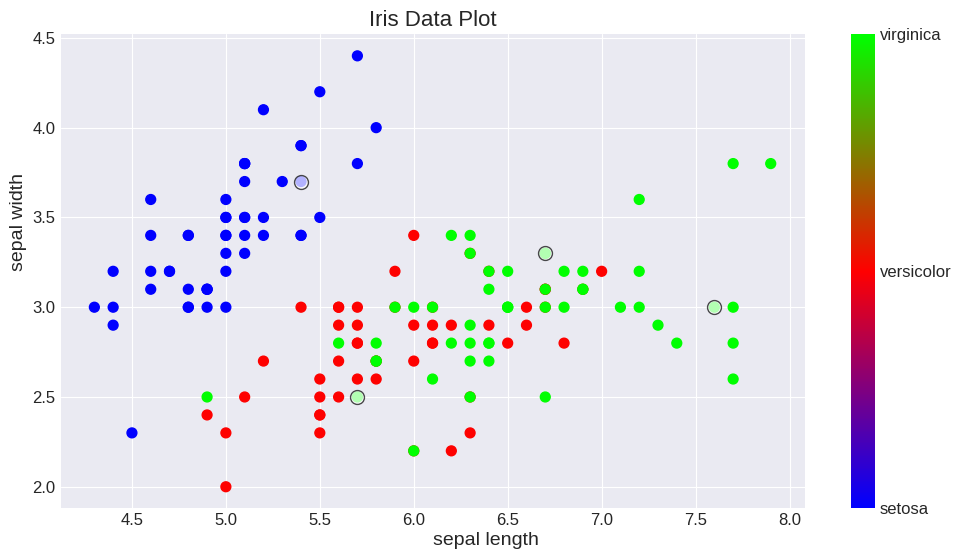

In [41]:
# Plot the data points

# Create a figure of given size
fig = plt.figure(figsize=(12,6))

# Add a subplot
ax = fig.add_subplot(111)

# Set title
title = 'Iris Data Plot'

plt.scatter( iris_df[xplot], iris_df[yplot], s = 50, 
            c = iris_df['target'], 
            cmap=plt.cm.brg) # , 

plt.colorbar(ticks=[0, 1, 2], format=formatter)

plt.scatter(x_err, y_err, color = "w", label="mismatch", 
            s = 100, alpha = 0.7, edgecolor = 'black')

# Grid lines inside plot can be set as True or False
ax.grid(True)

# Plot frame can be set as true or false
ax.set_frame_on(True)

 
# Customize title, set position, allow space on top of plot for title
ax.set_title(title, fontsize=16, ha='center')

plt.subplots_adjust(top=0.9)

ax.title.set_position((0.5,1))

# Set x axis label
ax.xaxis.set_label_position('bottom')

ax.set_xlabel(xplot, fontsize=14,  ha='left') 

ax.xaxis.set_label_coords(0.5, -0.05)

# Set y axis label
ax.set_ylabel(yplot, fontsize=14,  ha='left') 

plt.show()

In [42]:
iris_correct = iris_df[(y == y_pred)]


accuracy = (iris_correct.shape[0]/iris_df.shape[0])

print ("We have predicted {:d} points correctly out of {:d} points".format (
        iris_correct.shape[0],iris_df.shape[0] ))

print ("Hence, the accuracy is {:5.3f}".format(accuracy))

We have predicted 146 points correctly out of 150 points
Hence, the accuracy is 0.973


In [43]:
accuracy = accuracy_score(y, y_pred)

print ("The accuracy is {:5.3f}".format(accuracy))

The accuracy is 0.973


In [44]:
## Multinomial

# instantiate
clf= LogisticRegression(penalty=None,
                        multi_class='multinomial',
                        random_state=RANDOM_STATE)


# fit the classifier
clf.fit(X_train, y_train)

# make predictions
y_pred = clf.predict(X_test)

y_pred = np.hstack([clf.predict(X_train), y_pred])
y = np.hstack([y_train, y_test])

In [45]:
# Let's use first two columns of the data and plot the data to visualize the results
xplot = iris_df.keys()[0]

yplot = iris_df.keys()[1]


# also locate instances which are incorrectly predicted.
x_err = iris_df[xplot][(y != y_pred)]
y_err = iris_df[yplot][(y != y_pred)]

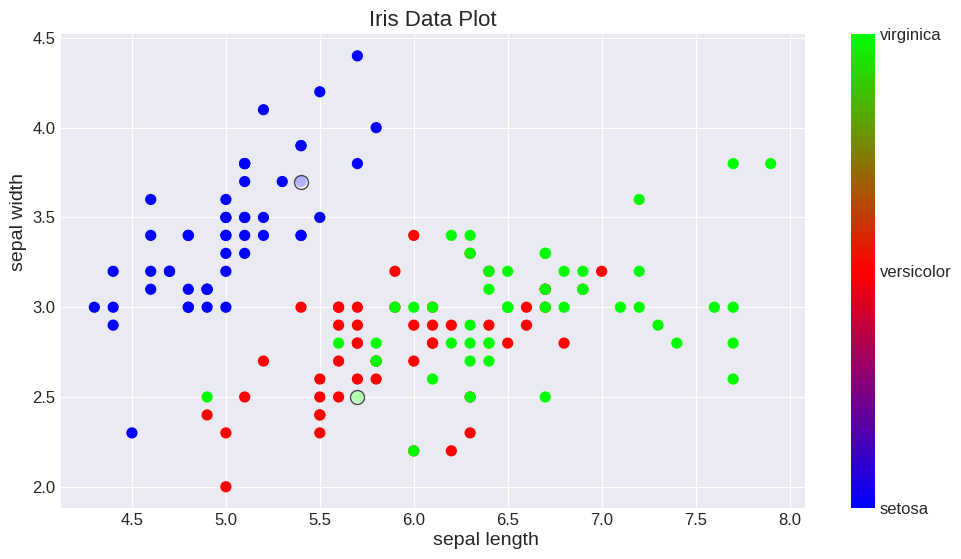

In [46]:
# Plot the data points

# Create a figure of given size
fig = plt.figure(figsize=(12,6))

# Add a subplot
ax = fig.add_subplot(111)

# Set title
title = 'Iris Data Plot'

plt.scatter( iris_df[xplot], iris_df[yplot], s = 50, 
            c = iris_df['target'], 
            cmap=plt.cm.brg) # , 

plt.colorbar(ticks=[0, 1, 2], format=formatter)

plt.scatter(x_err, y_err, color = "w", label="mismatch", 
            s = 100, alpha = 0.7, edgecolor = 'black')

# Grid lines inside plot can be set as True or False
ax.grid(True)

# Plot frame can be set as true or false
ax.set_frame_on(True)

 
# Customize title, set position, allow space on top of plot for title
ax.set_title(title, fontsize=16, ha='center')

plt.subplots_adjust(top=0.9)

ax.title.set_position((0.5,1))

# Set x axis label
ax.xaxis.set_label_position('bottom')

ax.set_xlabel(xplot, fontsize=14,  ha='left') 

ax.xaxis.set_label_coords(0.5, -0.05)

# Set y axis label
ax.set_ylabel(yplot, fontsize=14,  ha='left') 

plt.show()

In [48]:
accuracy_score(y, y_pred)

0.9866666666666667